In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd

from algorithms.utils import train_test_split

from algorithms.ConfusionMatrix import ConfusionMatrix

from algorithms.Gaussian import QuadraticGaussianClassifier, NormalNaiveBayes
from algorithms.NearestNeighbors import NearestCentroidClassifier
from algorithms.Quadratic import QuadraticClassifier

from sklearn.neighbors import KNeighborsClassifier

import logging

logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
df = pd.read_csv("../datasets/default of credit card clients.csv", delimiter=',')
df.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df['Y'].value_counts()

0    23364
1     6636
Name: Y, dtype: int64

In [34]:
data = np.loadtxt("../datasets/default of credit card clients.csv", delimiter=',', skiprows=1)
data.shape

(30000, 25)

In [2]:
def run_experiments(data, times = 100):
    logger.setLevel(logging.CRITICAL)
    models = {
        "NB": NormalNaiveBayes(),
        "CQ(P)": 
            QuadraticClassifier(check_invertibility=True,pinv_mode="pooled"),
        "CQG(P)": 
            QuadraticGaussianClassifier(check_invertibility=True,pinv_mode="pooled"),
        "CQ(F)": 
            QuadraticClassifier(check_invertibility=True,pinv_mode="friedman"),
        "CQG(F)": 
            QuadraticGaussianClassifier(check_invertibility=True,pinv_mode="friedman"),
        "DMC": NearestCentroidClassifier(),
        "KNN(k=11)": KNeighborsClassifier(n_neighbors=11),
#         "KNN(k=11)": KNNClassifier(k=11),
        "NN": KNeighborsClassifier(n_neighbors=1)
#         "NN": NNClassifier()
    }

    acc_results = []
    metrics_results = []
    for model_name in models:
        print("Running model {}".format(model_name))
        model = models[model_name]
        min_score = 101
        max_score = -1

        scores = []
        sensitivities = []
        specificities = []
        precisions = []
        for _ in range(times):
            
            train,test = train_test_split(data,.8, shuffle=True)
            model.fit(train[:,:-1],train[:,-1])
            
            predicted = []
            for x in test[:,:-1]:
                try:
                    y = model.predict(x)
                except Exception:
                    y = model.predict(x.reshape(1, -1))
                    
                if isinstance(y,list):
                    predicted.append(y[0])
                else:
                    predicted.append(y)
                
            conf_matrix = ConfusionMatrix(test[:,-1],predicted)

            sensitivities.append(conf_matrix.sensitivity())
            specificities.append(conf_matrix.specificity())
            precisions.append(conf_matrix.precision())

            score = conf_matrix.accuracy()
            scores.append(score)

            if score > max_score:
                max_score = score

            if score < min_score:
                min_score = score

        mean = np.mean(scores)
        std = np.std(scores)
        median = np.median(scores)

        acc_results.append({
            "1 - Alg": model_name,
            "2 - Média(%)": mean*100,
            "3 - Mediana(%)": median*100,
            "4 - Min/Max(%)": "{:.1f} / {:.1f}".format(min_score*100,max_score*100),
            "5 - Desv. Pad.(%)": std*100
        })
        
        metrics_results.append({
            "1 - Alg": model_name,
            "6 - Sensibilidade(%)": np.mean(sensitivities)*100,
            "7 - Especificidade(%)": np.mean(specificities)*100,
            "8 - Precisão(%)": np.mean(precisions)*100
        })

    return pd.DataFrame(acc_results).round(1), pd.DataFrame(metrics_results).round(1)

In [13]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)


/home/jupyter/miniconda3/envs/jupyter/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,70.5,71.0,61.2 / 77.6,3.9
1,CQ(P),65.0,77.7,21.6 / 79.2,23.4
2,CQG(P),65.0,77.7,21.6 / 79.2,23.4
3,CQ(F),77.8,77.8,76.7 / 79.2,0.5
4,CQG(F),65.0,77.7,21.6 / 79.2,23.4
5,DMC,53.6,53.6,52.2 / 54.9,0.5
6,KNN(k=11),76.7,76.7,75.7 / 78.2,0.5
7,NN,68.7,68.7,67.7 / 70.0,0.5


In [14]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,65.3,72.0,40.6
1,CQ(P),23.0,77.0,5.1
2,CQG(P),23.0,77.0,5.1
3,CQ(F),0.0,100.0,0.0
4,CQG(F),23.0,77.0,5.1
5,DMC,67.1,49.8,27.6
6,KNN(k=11),12.5,95.1,42.0
7,NN,29.0,80.0,29.3


## Clusterizando

In [6]:
from sklearn.cluster import KMeans

100
200
300
400
500
600
700
800
900
1000


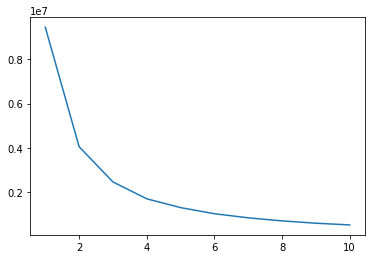

In [51]:
ssds = []
for k in range(100,1001,100):
    d = data[data[:,-1]==0.0]
    print(k)
    model = KMeans(n_clusters=k, max_iter = 10)
    y = model.fit_predict(d[:,:-1])
    ssd = 0
    for x,y in zip(d,y):
        ssd += np.linalg.norm(model.cluster_centers_[y] - x[:-1])
    
    ssds.append(ssd/k)

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.plot(range(1,len(ssds)+1), ssds);

In [12]:
from sklearn.cluster import KMeans

def generate_prototypes(data,k,attempts = 1):
    classes = np.unique(data[:,-1])
    n = data.shape[1]
    clusterized_data = np.reshape(np.zeros(n),(1,n))
    for c in classes:
        prototypes = []
        d = data[data[:,-1]==c]
        for _ in range(attempts):
            model = KMeans(n_clusters=k, max_iter = 10)
            y = model.fit_predict(d[:,:-1])
            ssd = 0
            for x,y in zip(d,y):
                ssd += np.linalg.norm(model.cluster_centers_[y] - x[:-1])
            
            prototypes.append((ssd,model.cluster_centers_))
        
        best_prototype = sorted(prototypes, key= lambda x: x[0])[0][1]
        
        y = np.array([c for _ in range(k)])
        clusterized_data = np.append(clusterized_data,np.c_[best_prototype,y],axis=0)

    return clusterized_data[1:,:]

In [66]:
data = np.loadtxt("../datasets/default of credit card clients.csv", delimiter=',',skiprows=1)
data = generate_prototypes(data, 400)
# np.savetxt("clustered-data-1000.csv",data,delimiter=',')
# data = np.loadtxt("clustered-data-1000.csv",delimiter=',')
data.shape

(800, 25)

In [67]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)
Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,68.0,68.1,56.2 / 81.9,4.6
1,CQ(P),49.8,50.0,40.6 / 57.5,3.6
2,CQG(P),49.9,50.0,41.2 / 61.3,3.7
3,CQ(F),50.3,50.3,43.8 / 60.0,3.2
4,CQG(F),50.7,51.2,43.1 / 59.4,3.5
5,DMC,56.7,56.9,46.9 / 67.5,3.8
6,KNN(k=11),50.3,50.6,41.9 / 58.1,3.5
7,NN,25.4,25.0,17.5 / 32.5,3.0


In [20]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,88.9,47.8,63.0
1,CQ(P),41.0,59.0,20.8
2,CQG(P),59.0,41.0,29.6
3,CQ(F),0.0,100.0,0.0
4,CQG(F),55.0,45.0,27.5
5,DMC,66.6,55.1,59.7
6,KNN(k=11),72.0,48.2,58.0
7,NN,32.2,39.3,34.7


## LDA

In [3]:
data = np.loadtxt("../datasets/default of credit card clients.csv", delimiter=',',skiprows=1)

def statistical_normalization(X):
    m = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    normalized_X = np.zeros((X.shape[0],X.shape[1]))
    for i,x in enumerate(X):
        normalized_X[i] = (x - m)/std
        
    return normalized_X

data[:,:-1] = statistical_normalization(data[:,:-1])

In [4]:
classes = {}
for (x,y) in zip(data[:,:-1],data[:,-1]):
    if not y in classes:
        classes[y] = []

    classes[y].append(x)

classes = {k: np.array(classes[k]) for k in classes}

In [6]:
n = data.shape[1]-1

sw = np.zeros((n,n))
m = np.mean(data[:,:-1],axis=0)
sb = np.zeros((n,n))

for k in classes:
    ni = classes[k].shape[0]
    mi = np.mean(classes[k],axis=0).reshape(n,1)
    mm = mi-m
#     sb += ni*np.outer(mi-m,mi-m)
    sb += ni * mm.dot(mm.T)
    
    s = np.zeros((n,n))
    for x in classes[k]:
        z = (x.reshape(n,1)-mi)
#         s += np.outer(z,z)
        s += z.dot(z.T)
    sw += s
    
sw.shape,sb.shape

((24, 24), (24, 24))

In [7]:
Z = np.linalg.inv(sw).dot(sb)
values, vectors = np.linalg.eig(Z,)

values = np.real(values)
vectors = np.real(vectors)

values

array([ 0.00000000e+00,  3.39780897e+00, -2.98158464e-15,  1.64947835e-15,
       -1.34804604e-15,  4.69163593e-16,  4.69163593e-16, -4.57577266e-16,
       -4.57577266e-16, -1.54450465e-16,  9.43119860e-17, -6.96727862e-17,
       -6.96727862e-17, -5.15544612e-17,  5.20827676e-17,  4.21570204e-17,
        4.21570204e-17, -1.44799293e-18, -1.44799293e-18, -2.22001562e-17,
       -2.22001562e-17,  1.57600076e-17, -6.61059612e-18,  4.35527421e-19])

In [8]:
pca_vectors = vectors[:,2]

data = np.c_[np.matmul(data[:,:-1],pca_vectors), data[:,-1]]
data.shape

(30000, 2)

In [9]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)
Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,76.8,76.7,75.9 / 77.8,0.4
1,CQ(P),77.2,77.2,75.3 / 78.8,0.6
2,CQG(P),77.9,77.9,76.8 / 78.5,0.4
3,CQ(F),77.3,77.4,75.5 / 78.7,0.7
4,CQG(F),77.8,77.8,76.8 / 78.8,0.5
5,DMC,49.4,47.1,45.3 / 54.2,3.4
6,KNN(k=11),76.7,76.7,75.7 / 78.1,0.5
7,NN,65.7,65.8,64.3 / 66.8,0.5


In [10]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,3.7,97.5,30.0
1,CQ(P),0.9,99.0,19.3
2,CQG(P),0.0,100.0,0.0
3,CQ(F),0.8,99.0,20.3
4,CQG(F),0.0,100.0,0.0
5,DMC,49.1,49.5,21.7
6,KNN(k=11),3.7,97.3,28.5
7,NN,23.1,77.8,22.8


In [13]:
data = generate_prototypes(data, 400)
# np.savetxt("clustered-data-1000.csv",data,delimiter=',')
# data = np.loadtxt("clustered-data-1000.csv",delimiter=',')
data.shape

(800, 2)

In [14]:
acc_df, metrics_df = run_experiments(data)
acc_df

Running model NB
Running model CQ(P)
Running model CQG(P)
Running model CQ(F)
Running model CQG(F)
Running model DMC
Running model KNN(k=11)
Running model NN


,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,47.0,47.5,38.8 / 56.9,3.6
1,CQ(P),48.3,48.1,40.6 / 55.6,3.6
2,CQG(P),48.6,48.8,40.0 / 58.8,3.8
3,CQ(F),48.0,48.1,41.9 / 55.0,3.0
4,CQG(F),48.5,48.8,38.8 / 55.6,3.6
5,DMC,49.4,49.4,40.0 / 58.1,3.4
6,KNN(k=11),36.3,36.2,27.5 / 46.9,3.7
7,NN,8.8,9.4,3.8 / 13.8,2.1


In [15]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,61.9,35.3,43.5
1,CQ(P),36.8,60.1,46.7
2,CQG(P),83.0,17.0,40.8
3,CQ(F),34.1,62.8,46.5
4,CQG(F),81.0,19.0,39.7
5,DMC,48.9,49.9,49.0
6,KNN(k=11),37.7,35.4,36.9
7,NN,9.0,8.8,8.8
